In [30]:
%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
df_raw = load_dataframe()

In [32]:
df_raw.head()

,text,label
0,US trade gap ballooned in October\n\nThe US tr...,business
1,Japanese mogul arrested for fraud\n\nOne of Ja...,business
2,Jarvis sells Tube stake to Spain\n\nShares in ...,business
3,Small firms 'hit by rising costs'\n\nRising fu...,business
4,Oil prices fall back from highs\n\nOil prices ...,business


In [33]:
PREPROCESSING_PIPELINE = [
                        lower,
                        remove_emails,
                        replace_special_characters,
                        replace_br,
                        filter_out_uncommon_symbols,
                        remove_stopwords,
                        strip_text
                    ]

In [34]:
print('Pre-processing text...')
 
print()
print(f'[Debug] Before:\n{df_raw.text.values[0]}')
print()
 
# Replace each sentence with its pre-processed version
df = df_raw.copy()
df['text'] = df_raw['text'].apply(lambda txt: text_prepare(txt, PREPROCESSING_PIPELINE))
 
print(f'[Debug] After:\n{df.text.values[0]}')
print()
 
print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
US trade gap ballooned in October

The US trade deficit widened by more than expected in October, hitting record levels after higher oil prices raised import costs, figures have shown

The trade shortfall was $55.5bn (£29bn), up 9% from September, the Commerce Department said. That pushed the 10 month deficit to $500.5bn. Imports rose by 3.4%, while exports increased by only 0.6%. A weaker dollar also increased the cost of imports, though this should help drive export demand in coming months. "Things are getting worse, but that's to be expected," said David Wyss of Standard & Poor's in New York. "The first thing is that when the dollar goes down, it increases the price of imports. "We are seeing improved export orders. Things seem to be going in the right direction."

Despite this optimism, significant concerns remain as to how the US will fund its trade and budget deficits should they continue to widen. Another problem highlighted by analysts wa

In [35]:
path = 'vocab/'
if not os.path.exists(path):
    os.makedirs(path)

# Check if vocabulary has already been built
vocab_regex = re.compile(r'idx_to_word\.pkl|word_to_idx\.pkl|word_listing\.pkl')

if len(os.listdir(path)) > 0 and all([vocab_regex.search(f) for f in os.listdir(path)]):
    print('Loading existing vocabulary...')
    idx_to_word, word_to_idx, word_listing = load_vocab()
    print('Vocabulary loaded!')
else:
    print('Building vocabulary...')
    idx_to_word, word_to_idx, word_listing = build_vocabulary(df)
    print('Saving vocabulary...')
    save_vocab(idx_to_word, word_to_idx, word_listing)
    print('Vocabulary built!')

Loading existing vocabulary...
Vocabulary loaded!


In [36]:
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df)

[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 31579/31579 [00:00<00:00, 455109.65it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 1000/1000 [00:00<00:00, 13470.66it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<00:00, 23967.45it/s]


In [37]:
df_train, df_test = split_dataframe(df)

In [38]:
print(f'Train size: {len(df_train)}')
df_train.head()

Train size: 800


,text,label
0,tory expert denies defeat warning conservative...,politics
1,article infospunj dan field writes ive invited...,medical
2,rendering programs require surface normals poi...,graphics
3,call kenteris cleared kostas kenteris lawyer c...,sport
4,brookside creators channel 4 bid creator defun...,entertainment


In [39]:
print(f'Test size: {len(df_test)}')
df_test.head()

Test size: 200


,text,label
0,eastern fronts 1914 learn war east 1914 easter...,historical
1,article callec dradja writes bit nervous posti...,space
2,bout info alleged supernova m81 might break sc...,space
3,collins appeals drugs ban sprinter michelle co...,sport
4,algerian war background french algeria conques...,historical


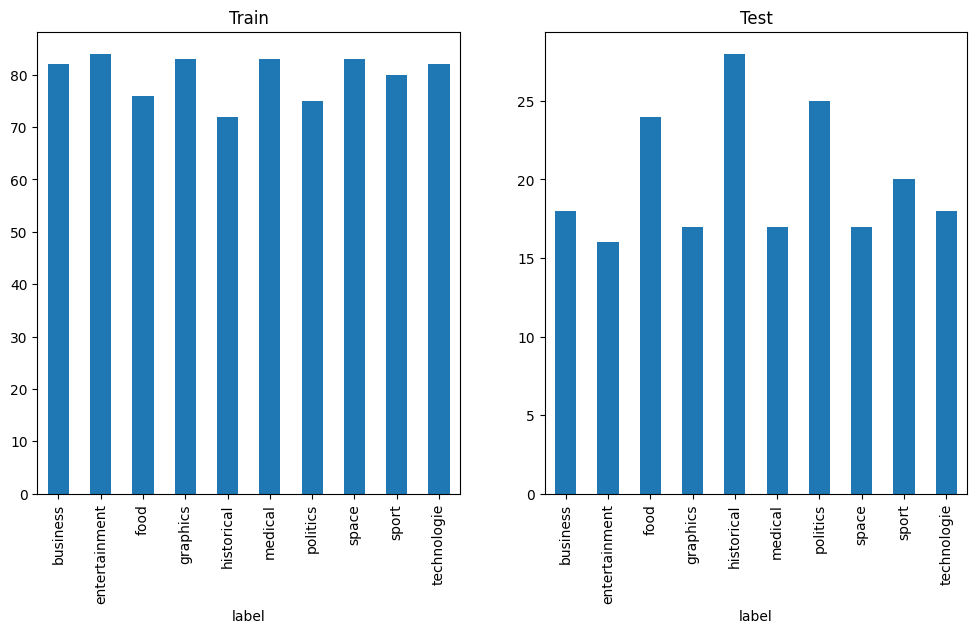

In [40]:
plot_label_distribution([df_train, df_test], labels=['Train', 'Test'])

## PMI

In [41]:
test_text = df_train.text.values[0]
print(f'[Debug] Test text:\n{test_text}')
print()
# TODO: should we remove stopwords here?
processed_text = text_prepare(test_text, PREPROCESSING_PIPELINE)
print(f'[Debug] Pre-processed test text:\n{processed_text}')
pmi, pmi_word_to_idx, pmi_idx_to_word = compute_pmi(processed_text)
print()


[Debug] Test text:
tory expert denies defeat warning conservatives campaign director denied report claiming warned michael howard party could win next general election times monday said australian lynton crosby told party leader focus trying increase tories commons presence 25 30 seats mr crosby said statement never conversation hold view mr howard later added one iota truth report strategist helped australias pm john howard win four elections mr howard appointed mr crosby elections chief last october mr crosbys statement said conservative party making impact issues lower tax controlled immigration past week added labour party wanting distract attention away issues really matter people

[Debug] Pre-processed test text:
tory expert denies defeat warning conservatives campaign director denied report claiming warned michael howard party could win next general election times monday said australian lynton crosby told party leader focus trying increase tories commons presence 25 30 seats mr 

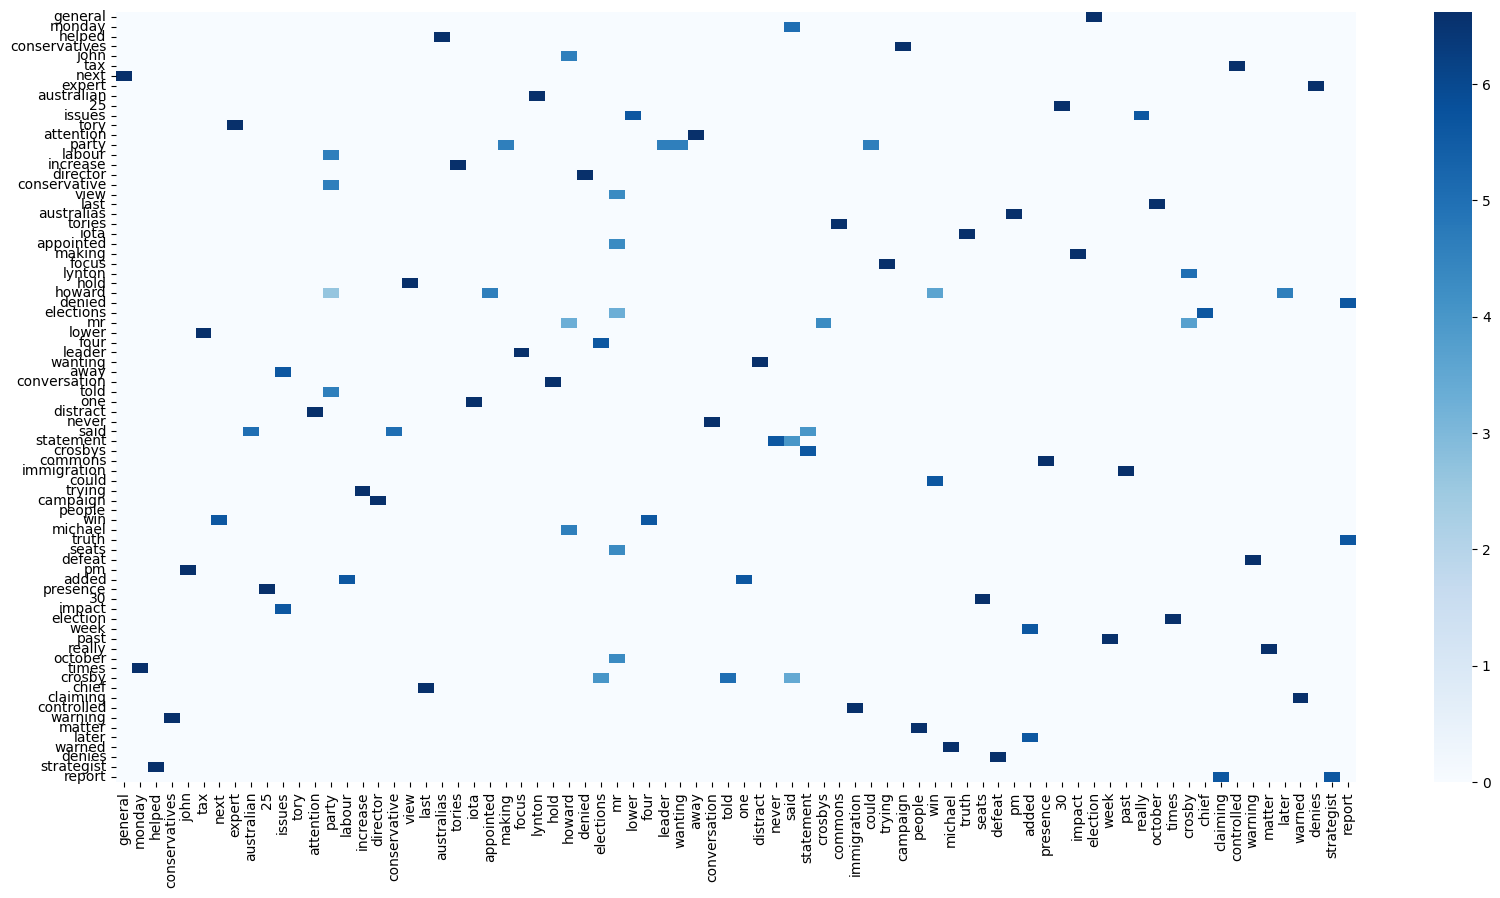

In [42]:
plot_pmi(pmi, pmi_idx_to_word)

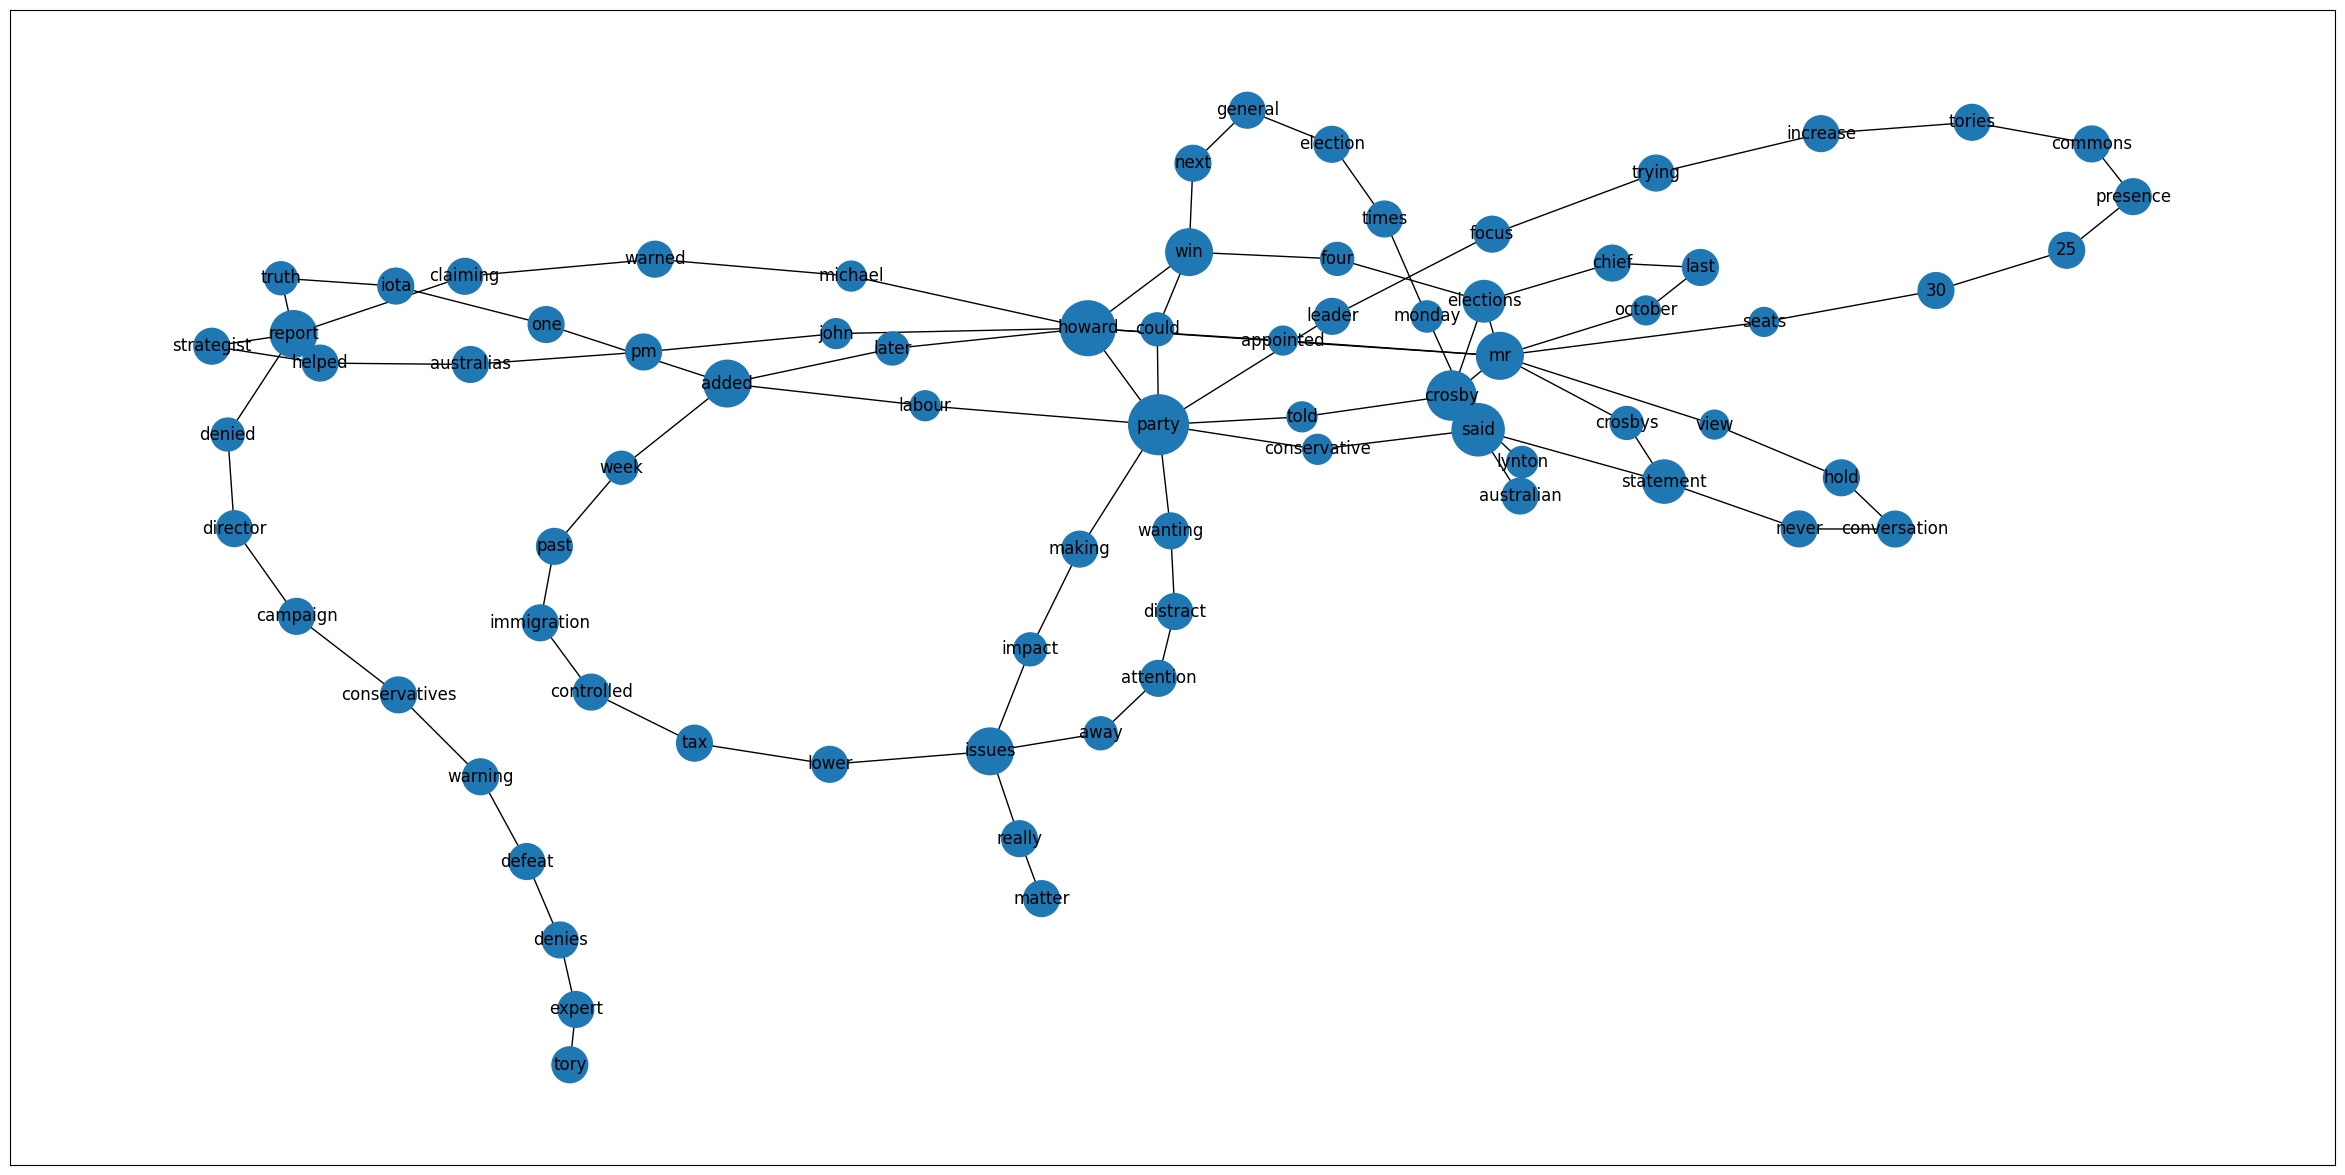

In [43]:
plot_pmi_graph(pmi, pmi_idx_to_word, pmi_word_to_idx)

In [44]:
sorted_pmi_values = sorted(pmi[pmi > 0], reverse=True)

In [45]:
num_values_gt_0 = len(sorted_pmi_values)
print(f'Number of values greater than 0: {num_values_gt_0}')
ratio = 2/3
idx = int(num_values_gt_0 * ratio)
threshold = sorted_pmi_values[idx]
print(f'Threshold: {threshold}')

Number of values greater than 0: 95
Threshold: 5.62


In [46]:
pmi2 = threshold_pmi(pmi, threshold)

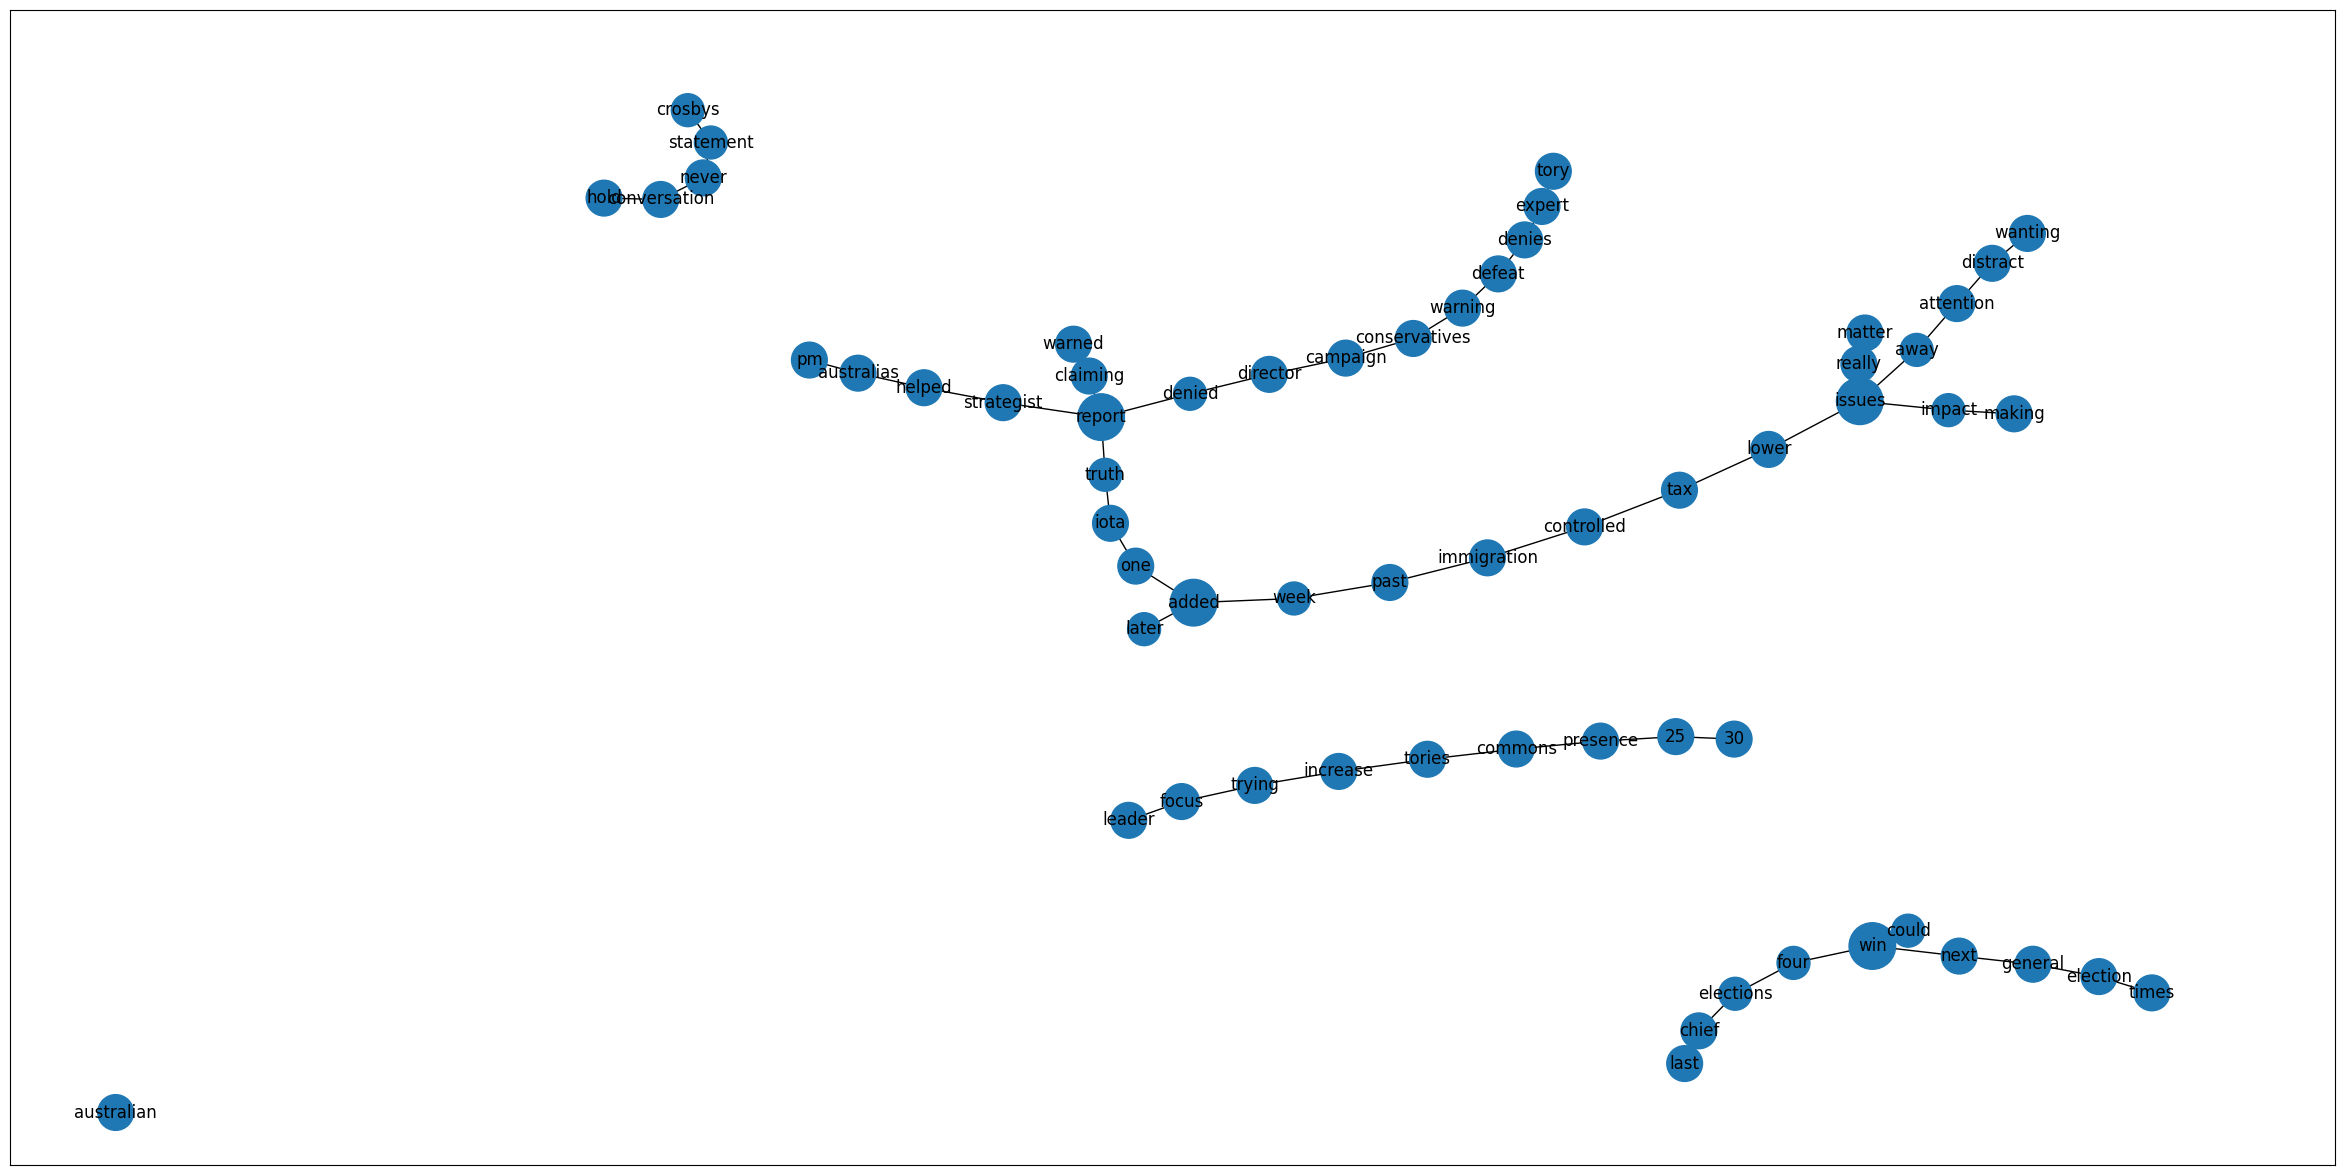

In [47]:
plot_pmi_graph(pmi2, pmi_idx_to_word, pmi_word_to_idx)